# This notebook is to perform EDA on the RNA expression and Deseq data

# Conclusions:
### 1. The log2FC min was -0.285 and max was 0.31. These are small numbers. It's consistent with the fact that most highly variable genes are just variable and have little to do with the Alc_status.
### 2. Patients 'X232', 'X442.1', 'X459', 'X98' were missing in the expression data. 

# Table of Contents
<font size=5><a href='#Loading-metadata,-expression-data-and-deseq-data'>1. Loading data</a></font></br>
<font size=5><a href='#Reproduce-the-volcano-plot-from-the-publication'>2. Reproduce the volcano plot from the paper</a></font></br>
<font size=5><a href='#Find-highly-variable-genes'>3. Find highly variable genes</a></font></br>
<font size=5><a href='#Plot-expression-of-highly-variable-genes'>4. Plot highly variable genes</a></font></br>
<font size=5><a href='#Check-patient-IDs-in-meta-and-expression-files'>5. Check patient IDs in metadata and expression file</a></font></br>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import umap
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline

# Loading metadata, expression data and deseq data

In [2]:
meta = pd.read_csv(r'G:\Shared drives\NIAAA_ASSIST\Data\kapoor2019_coga.inia.detailed.pheno.04.12.17.csv')

In [3]:
expression = pd.read_csv(r'G:\Shared drives\NIAAA_ASSIST\Data\kapoor2019_batch.age.rin.sex.pm.alc.corrected.coga.inia.expression.txt', sep = '\t')

In [4]:
deseq = pd.read_excel(r'G:\Shared drives\NIAAA_ASSIST\Data\deseq.alc.vs.control.age.rin.batch.gender.PMI.corrected.w.prot.coding.gene.name.xlsx')

# Reproduce the volcano plot from the publication

In [363]:
deseq.log2FoldChange.min()

-0.285737498334009

In [364]:
deseq.log2FoldChange.max()

0.312215081932713

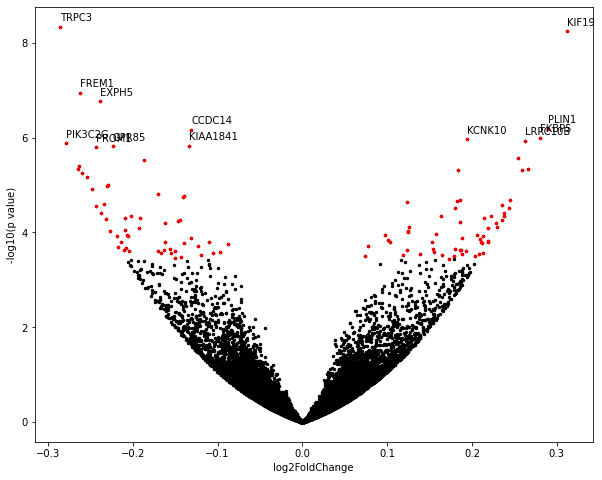

In [11]:
plt.figure(figsize = (10, 8))
plt.scatter(deseq.log2FoldChange, -1*np.log10(deseq.pvalue), color = 'k', s = 6)
plt.scatter(deseq.log2FoldChange[deseq.padj < 0.05], -1*np.log10(deseq.pvalue)[deseq.padj < 0.05], color = 'r', s = 6)
for i in deseq[deseq.padj < 0.003].index:
    x = deseq[deseq.padj < 0.003].loc[i, 'log2FoldChange']
    y = -1* np.log10(deseq[deseq.padj < 0.003].loc[i, 'pvalue'])
    plt.annotate(deseq[deseq.padj < 0.003].loc[i, 'gene'], (x,y), textcoords="offset points", xytext=(0,6))
plt.xlabel('log2FoldChange')
plt.ylabel('-log10(p value)')
plt.show();

<font size=5>The log2FC is between -0.3 and 0.3. It seems pretty small. This could mean the highly variable genes are NOT DEGs. They are not specifically different between the alcoholic and the control group.</font>

# Find highly variable genes

Text(0.5, 6.799999999999997, 'variance of gene expression')

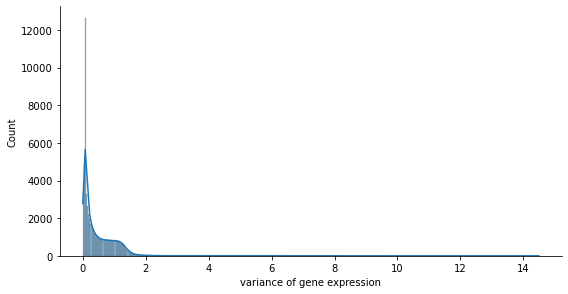

In [5]:
expression_var = expression.var(axis = 1)
sns.displot(expression_var, kde = True, height = 4, aspect = 2)
plt.xlabel('variance of gene expression')

## Find genes with large variance

In [6]:
# checking some highly variable genes with variance > 6
var_genes = expression[expression_var > 6]['id']

# Plot expression of highly variable genes

<font size=5>See if highly variable genes have different expression between control and alcoholic, not just different in all patients</font>

In [7]:
# subset the expression data for the highly variable genes
variable_exp = expression[expression.id.isin(var_genes)].T

In [8]:
# Rename the columns
variable_exp.columns = variable_exp.iloc[0, :]
variable_exp.drop('id', inplace = True)

In [9]:
variable_exp = variable_exp.apply(pd.to_numeric)

In [10]:
# merge the variable gene expression with metadata
variable_meta = pd.merge(variable_exp, meta, left_index = True, right_on = 'IID')

In [16]:
variable_meta.columns

Index(['ENSG00000207513', 'ENSG00000207005', 'ENSG00000134184',
       'ENSG00000214776', 'ENSG00000262539', 'ENSG00000204792',
       'ENSG00000230836', 'ENSG00000235833', 'ENSG00000115602',
       'ENSG00000184674', 'ENSG00000230847', 'ENSG00000263667',
       'ENSG00000226278', 'ENSG00000234449', 'ENSG00000205663', 'SUNumber',
       'IID', 'RNAsequencedby', 'Frozentissue', 'BMI', 'RIN', 'Age', 'Gender',
       'Ethnicity', 'Alc_status', 'Classification', 'DSMIV_LF_added', 'DSMIV',
       'DSMV', 'PM!', 'Brain_pH', 'COD_category', 'Agonal_phase',
       'Liver_class', 'Smoking_frequency', 'Pack_yrs_1_pktperday_1_yr)',
       'AUDIT', 'alcohol_intake_gmsperday', 'Total_drinking_yrs', 'Depression',
       'Anxiety', 'SR'],
      dtype='object')

## Try a few categories to see if they are responsible for the bimodal expression

In [47]:
id_vars = ['Alc_status', 'RNAsequencedby', 'Frozentissue', 'Agonal_phase', 'Ethnicity', 'Liver_class']
melt_variable_meta= pd.melt(variable_meta, id_vars = id_vars, value_vars = variable_exp.columns[:5],
                            var_name = 'ID', value_name = 'CPM')

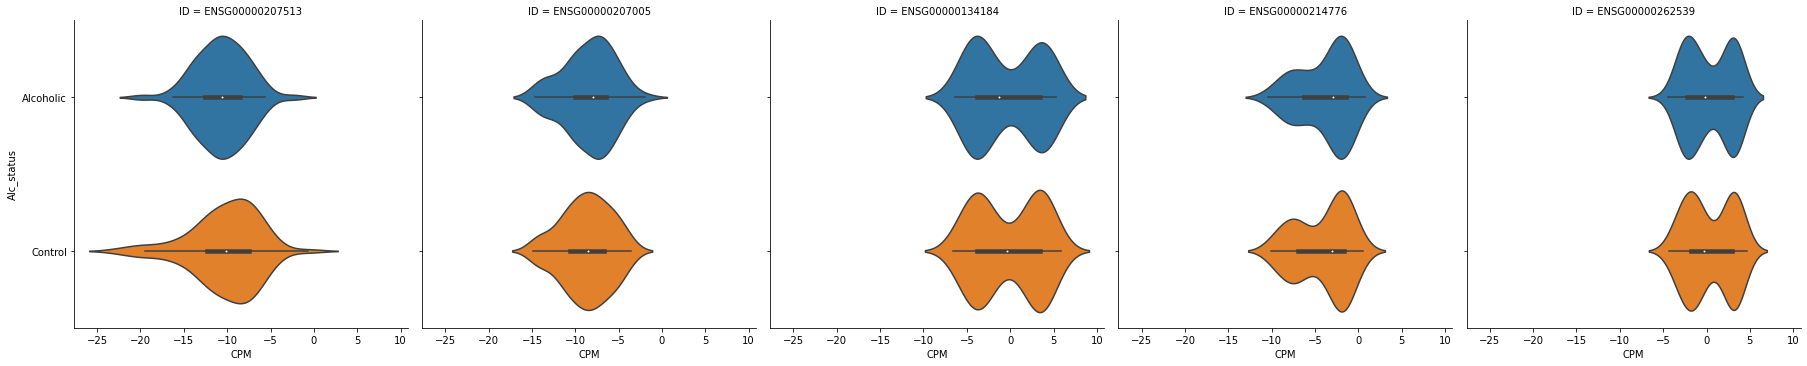

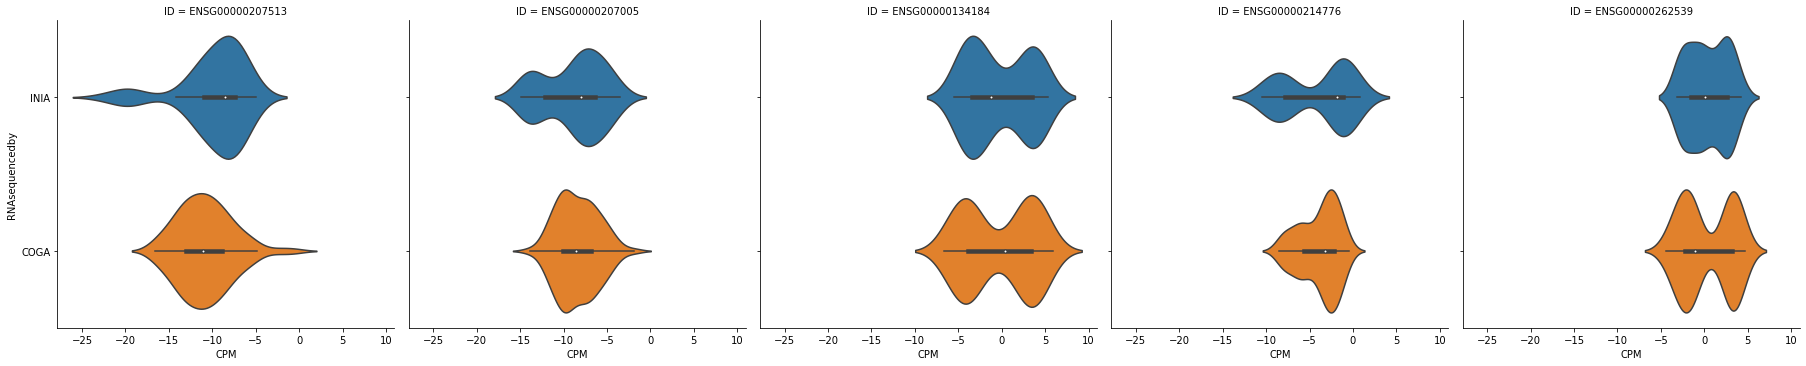

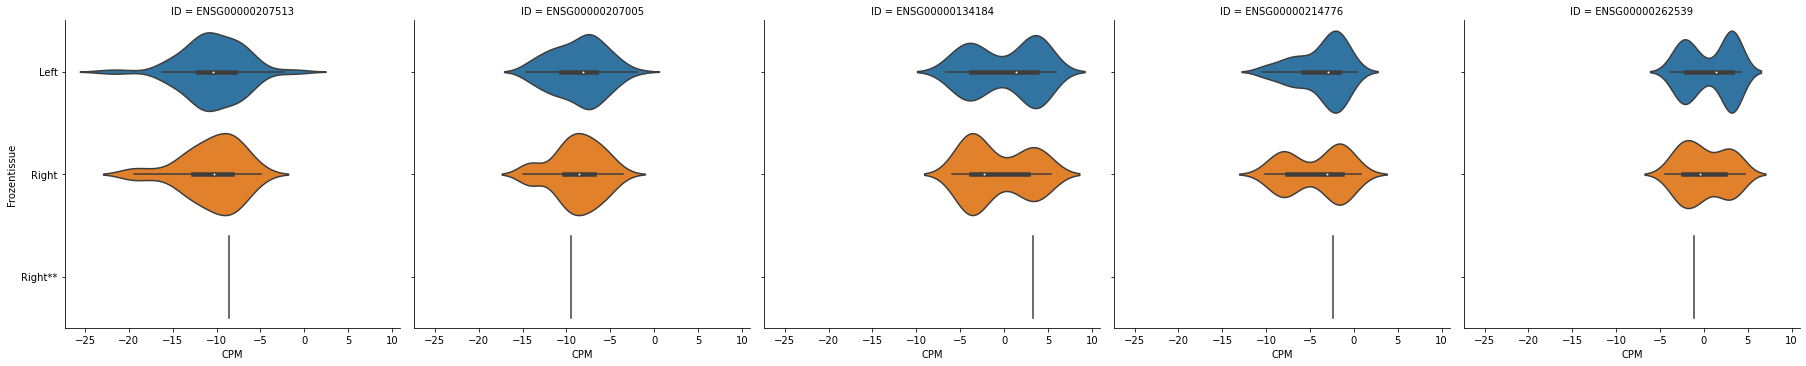

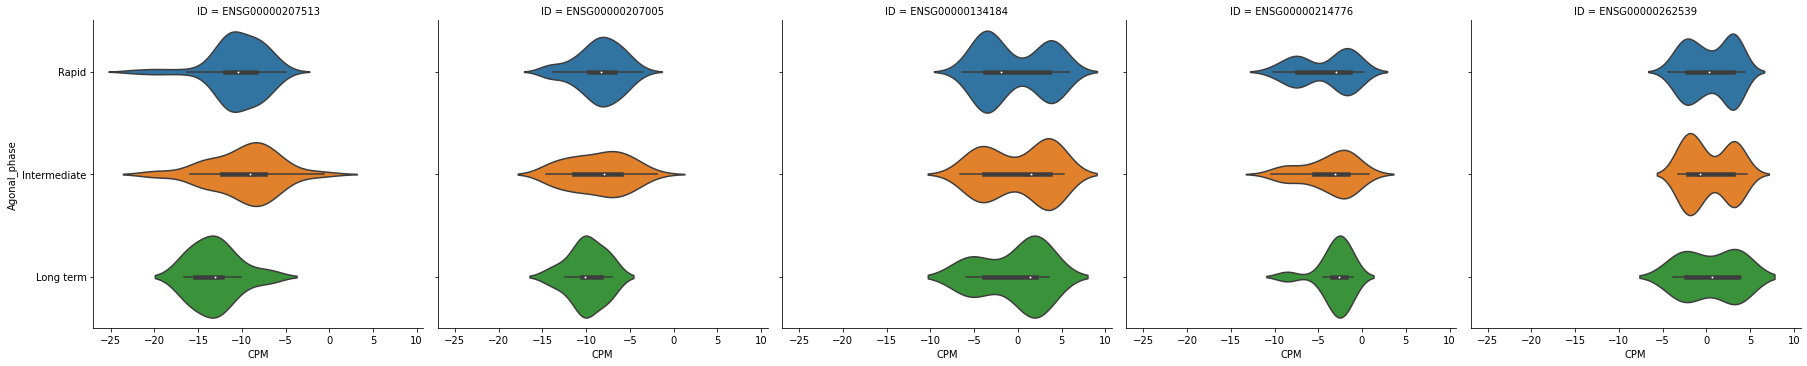

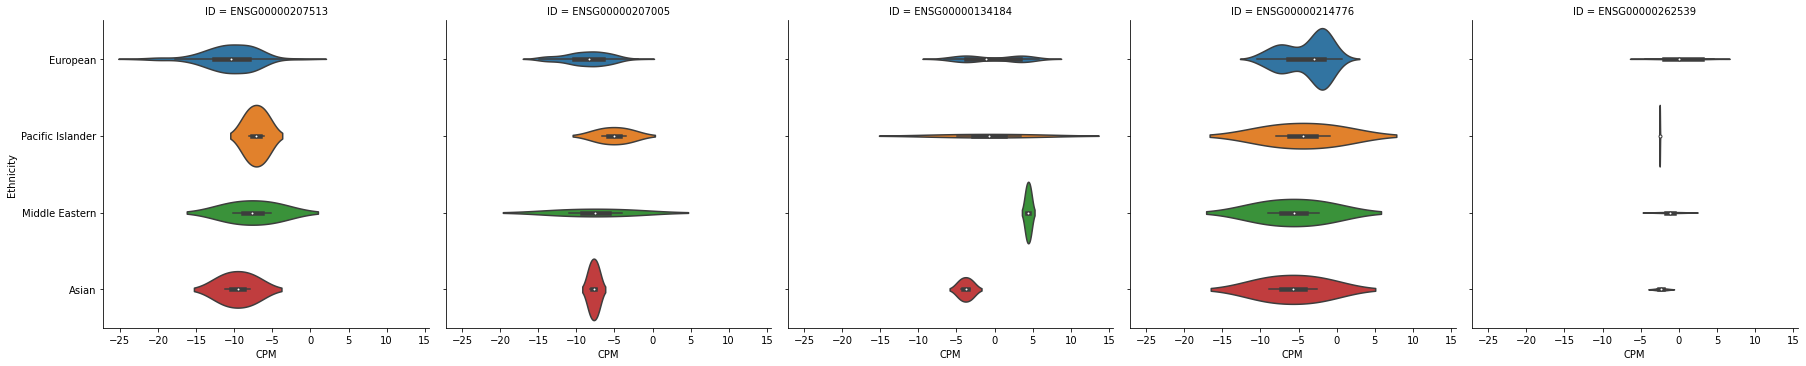

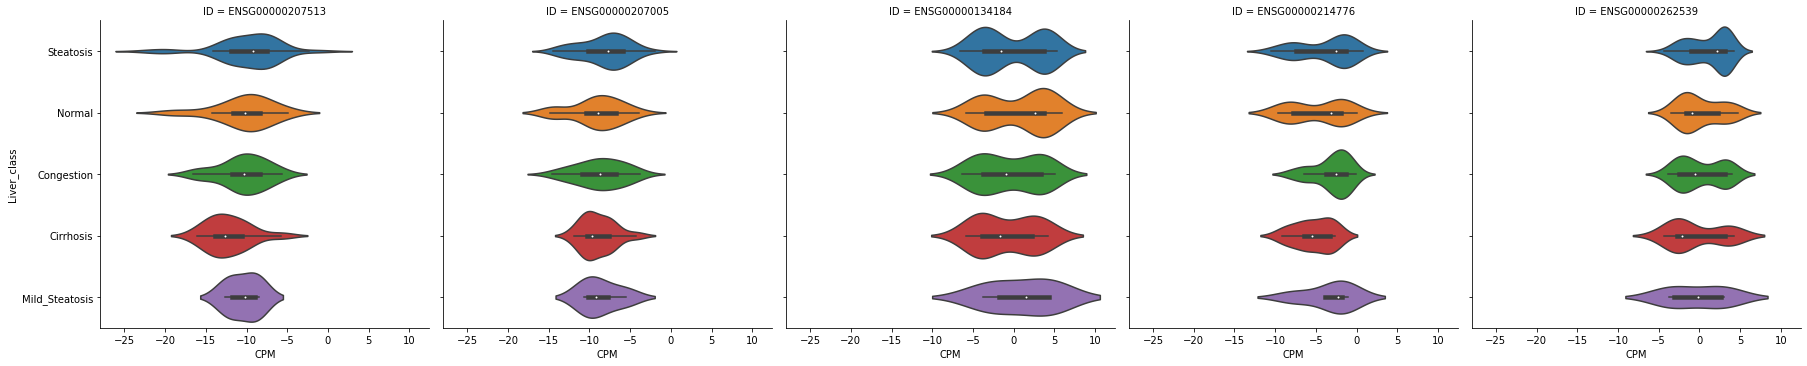

In [48]:
for col in id_vars:
    sns.catplot(x='CPM', y=col, data=melt_variable_meta, col = 'ID', col_wrap = 5, kind = 'violin')
    plt.show()
    plt.close()

In [14]:
melt_variable_meta.head()

,Alc_status,ID,CPM
0,Alcoholic,ENSG00000207513,-12.128961
1,Control,ENSG00000207513,-4.970308
2,Alcoholic,ENSG00000207513,-8.764222
3,Control,ENSG00000207513,-6.966556
4,Alcoholic,ENSG00000207513,-6.852766


In [ ]:
sns.catplot(x='CPM', y='Alc_status', 
            data=melt_variable_meta, col = 'ID', col_wrap = 4, kind = 'violin')

## Highly variable genes were variable across the samples, not specifically variable across the Alc_status

In [358]:
print(len(list(set(var_genes) - set(deseq.id))), 'out of 15 highly variable genes are not in the deseq data')

15 out of 15 highly variable genes are not in the deseq data


In [360]:
# lower cutoff for variable genes
var_genes2 = expression[expression_var > 5]['id']
print(len(list(set(var_genes2) - set(deseq.id))), f'out of {len(var_genes2)} highly variable genes are not in the deseq data')

25 out of 28 highly variable genes are not in the deseq data


# Check patient IDs in meta and expression files

In [213]:
# patients in metadata but not in expression file
set(meta.IID) - set(expression.columns[1:])

{'X232', 'X442.1', 'X459', 'X98'}

In [361]:
# patients in expression but not in metadata
set(expression.columns[1:]) -set(meta.IID)

set()

## Patients X232', 'X442.1', 'X459', 'X98' were in the metadata but not in the expression file.